## Spotify App Reviews Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:

from google.colab import files
import io
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['reviews.csv']))
print(df)

Saving reviews.csv to reviews.csv
            Time_submitted                                             Review  \
0      2022-07-09 15:00:00  Great music service, the audio is high quality...   
1      2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2      2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3      2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4      2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   
...                    ...                                                ...   
61589  2022-01-01 03:01:29  Even though it was communicated that lyrics fe...   
61590  2022-01-01 02:13:40  Use to be sooo good back when I had it, and wh...   
61591  2022-01-01 01:02:29  This app would be good if not for it taking ov...   
61592  2022-01-01 00:49:23  The app is good hard to navigate and won't jus...   
61593  2022-01-01 00:19:09  Its good but sometimes it doesnt load the musi.

### Data PreProcessing

In [23]:
stf = df.copy()

In [24]:
import gensim
from gensim.parsing.preprocessing import strip_non_alphanum, strip_multiple_whitespaces, preprocess_string, split_alphanum, strip_short, strip_numeric
import re 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def lower_case(docs):
  return [doc.lower() for doc in docs]

def remove_punc(docs):
  # Loai bo dau cau & ki tu dac biet
  return [strip_non_alphanum(doc).strip() for doc in docs]

def separate_num(docs):
  # Tach cac so va chu lien nhau
  return [split_alphanum(doc) for doc in docs]

def remove_one_letter_word(docs):
  return [strip_short(doc) for doc in docs]

def remove_number(docs):
  return [strip_numeric(doc) for doc in docs]

def replace_multiple_whitespaces(docs):
  # Thay the nhieu spaces bang mot space
  return [strip_multiple_whitespaces(doc) for doc in docs]

def remove_stopwords(docs):
    return [" ".join([word for word in doc.split() if word not in stop_words]) for doc in docs]

doc = lower_case(stf['Review'])
doc = remove_punc(doc)
doc = separate_num(doc)
doc = remove_one_letter_word(doc)
doc = remove_number(doc)
doc = replace_multiple_whitespaces(doc)
doc = remove_stopwords(doc)

stf['Review'] = doc

In [26]:
stf.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,great music service audio high quality app eas...,5,2,NaN
1,2022-07-09 14:21:22,please ignore previous negative rating app sup...,5,1,NaN
2,2022-07-09 13:27:32,pop get best spotify experience android annoyi...,4,0,NaN
3,2022-07-09 13:26:45,really buggy terrible use recently,1,1,NaN
4,2022-07-09 13:20:49,dear spotify get songs put playlist shuffle play,1,1,NaN


In [27]:
stf1 = stf.copy()
rate = [1,2,3,4,5]
sentiment = [0, 0, 1, 1, 1]
for i in range(5):
    stf1["Rating"].replace(rate[i], sentiment[i],inplace=True)

In [28]:
stf1.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,great music service audio high quality app eas...,1,2,NaN
1,2022-07-09 14:21:22,please ignore previous negative rating app sup...,1,1,NaN
2,2022-07-09 13:27:32,pop get best spotify experience android annoyi...,1,0,NaN
3,2022-07-09 13:26:45,really buggy terrible use recently,0,1,NaN
4,2022-07-09 13:20:49,dear spotify get songs put playlist shuffle play,0,1,NaN


### RNN

In [62]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
x_train, x_test, y_train, y_test = train_test_split(stf1['Review'], stf1['Rating'], test_size=0.2, random_state=42)
print(x_train[0])

# Tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
print(x_train[0:1])
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
print(x_train[0])

# Pad the sequences to make all inputs the same length
max_length = max([len(s) for s in x_train])
print(max_length)

great music service audio high quality app easy use also quick friendly support
3305    man spotify great know put covid warning appro...
Name: Review, dtype: object
[816, 3, 13, 71, 162, 1062, 1418, 2717, 516, 317, 285, 61]
311


In [51]:
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')

In [52]:
x_valid, y_valid = x_train[:1000], y_train[:1000]
x_train_, y_train_ = x_train[1000:], y_train[1000:]

In [14]:
x_train[0]

array([ 816,    3,   13,   71,  162, 1062, 1418, 2717,  516,  317,  285,
         61,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [41]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
 
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


#### simple RNN (Vanilla RNN)

In [35]:
embd_len = 32

RNN_model = Sequential(name="Simple_RNN")
RNN_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))

RNN_model.add(SimpleRNN(64, activation='tanh', return_sequences=False))

RNN_model.add(Dense(1, activation='sigmoid'))

print(RNN_model.summary())

RNN_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

history = RNN_model.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_valid, y_valid))

# model score on test data
print()
print("Simple_RNN Score---> ", RNN_model.evaluate(x_test, y_test, verbose=0))


Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 311, 32)           636544    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                6208      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 642,817
Trainable params: 642,817
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
755/755 [==============================] - 91s 119ms/step - loss: 0.6754 - accuracy: 0.5932 - val_loss: 0.6754 - val_accuracy: 0.6020
Epoch 2/10
755/755 [==============================] - 87s 115ms/step - loss: 0.6757 - accuracy: 0.5965 - val_loss: 0.6820 - val_accuracy: 0.6020
Epoch 3/10
755/755 

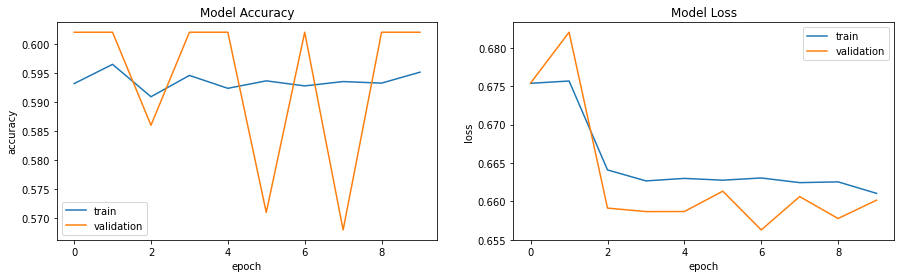

In [42]:
plot_training_hist(history)


The vanilla form of RNN gave us a Test Accuracy of 60.13%. Limitations of Simple RNN are it is unable to handle long sentences well because of its vanishing gradient problems.

#### GRU (Gated Recurent Units)

In [ ]:
gru_model = Sequential(name="GRU_Model")
gru_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))
gru_model.add(GRU(64, activation='tanh', return_sequences=False))
gru_model.add(Dense(16, activation='relu'))
gru_model.add(Dense(1, activation='relu'))

print(gru_model.summary())

gru_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

history2 = gru_model.fit(x_train_, y_train_, batch_size=64, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

print()
print("GRU model Score---> ", gru_model.evaluate(x_test, y_test, verbose=0))


Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 311, 32)           636544    
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 656,417
Trainable params: 656,417
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
769/769 [==============================] - 12s 14ms/step - loss: 0.6876 - accuracy: 0.5928 - val_loss: 0.7021 - val_accuracy: 0.5312
Epoch 2/20
769/769 [==============

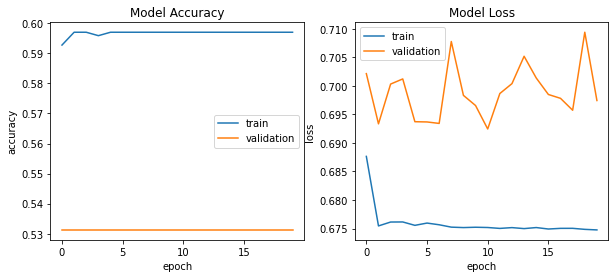

In [ ]:
plot_training_hist(history2)

Test Accuracy of GRU was found to be 60.15%. GRU is a form of RNN that are better than simple RNN and are often faster than LSTM due to its relatively fewer training parameters.

#### LSTM

In [57]:
lstm_model = Sequential(name="LSTM_Model")
lstm_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))
lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
# lstm_model.add(Dense(16, activation='sigmoid'))
lstm_model.add(Dense(1))

print(lstm_model.summary())

lstm_model.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

history3 = lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_valid, y_valid))

print()
print("LSTM model Score---> ", lstm_model.evaluate(x_test, y_test, verbose=0))

 68/755 [=>............................] - ETA: 4:55 - loss: 9.1940 - accuracy: 0.4040

KeyboardInterrupt: ignored

In [55]:
plot_training_hist(history3)

NameError: ignored

LSTM + Dropout

In [63]:
lstm_model = Sequential(name="LSTM_Model")
lstm_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))
lstm_model.add(LSTM(16, activation='tanh', return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(1, activation='softmax'))

print(lstm_model.summary())

lstm_model.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

history4 = lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_valid, y_valid))

print()
print("LSTM model Score---> ", lstm_model.evaluate(x_test, y_test, verbose=0))


Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 311, 32)           636544    
                                                                 
 lstm_14 (LSTM)              (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 16)                272       
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 639,969
Trainable params: 639,969
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
755/755 [=========================

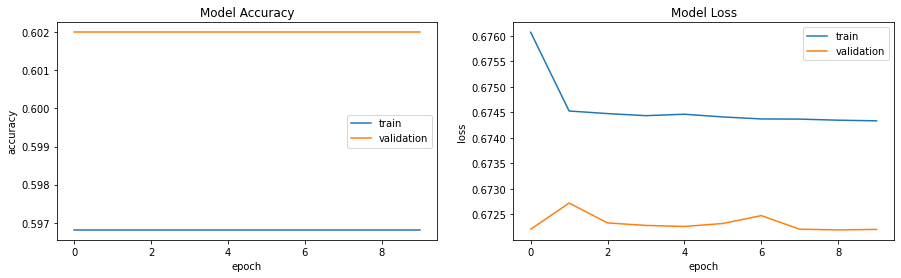

In [64]:
plot_training_hist(history4)

#### Bi-Directional LSTM

In [60]:
bi_lstm_model = Sequential(name="Bidirectional_LSTM")
bi_lstm_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))
bi_lstm_model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(32)))
bi_lstm_model.add(Dense(16, activation='relu'))
bi_lstm_model.add(Dense(1, activation='relu'))

print(bi_lstm_model.summary())

bi_lstm_model.compile(
loss="binary_crossentropy",
optimizer='adam',
metrics=['accuracy']
)

history5 = bi_lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=20, verbose=1, validation_data=(x_test, y_test))

print()
print("Bidirectional LSTM model Score---> ", bi_lstm_model.evaluate(x_test, y_test, verbose=0))


Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 311, 32)           636544    
                                                                 
 bidirectional_2 (Bidirectio  (None, 311, 128)         49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_25 (Dense)            (None, 16)                1040      
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 728,481
Trainable params: 728,481


KeyboardInterrupt: ignored

In [ ]:
plot_training_hist(history5)

Bi Directional 2

In [ ]:
bi_lstm_model = Sequential(name="Bidirectional_LSTM")
bi_lstm_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))
bi_lstm_model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=False)))
# bi_lstm_model.add(Bidirectional(LSTM(32)))
bi_lstm_model.add(Dense(16, activation='relu'))
bi_lstm_model.add(Dense(1, activation='relu'))

print(bi_lstm_model.summary())

bi_lstm_model.compile(
loss="binary_crossentropy",
optimizer='adam',
metrics=['accuracy']
)

history6 = bi_lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_test, y_test))

print()
print("Bidirectional LSTM model Score---> ", bi_lstm_model.evaluate(x_test, y_test, verbose=0))


Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 311, 32)           636544    
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 16)                2064      
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 688,289
Trainable params: 688,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
769/769 [==============================] - 25s 29ms/step - loss: 0.4853 - accuracy: 0.7782 -

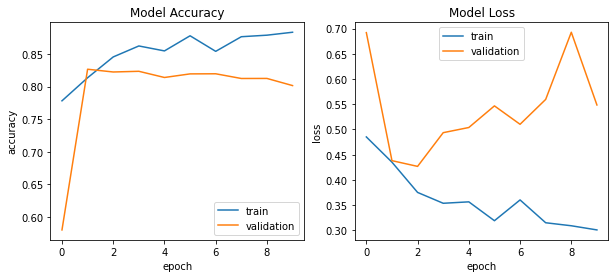

In [ ]:
plot_training_hist(history6)

Bi 3

In [ ]:
bi_lstm_model = Sequential(name="Bidirectional_LSTM")
bi_lstm_model.add(Embedding(len(tokenizer.word_index)+1, embd_len, input_length=max_length))
bi_lstm_model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(16, activation='relu'))
bi_lstm_model.add(Dense(1, activation='relu'))

print(bi_lstm_model.summary())

bi_lstm_model.compile(
loss="binary_crossentropy",
optimizer='adam',
metrics=['accuracy']
)

history7 = bi_lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_test, y_test))

# Printing model score on test data
print()
print("Bidirectional LSTM model Score---> ", bi_lstm_model.evaluate(x_test, y_test, verbose=0))


Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 311, 32)           636544    
                                                                 
 bidirectional_9 (Bidirectio  (None, 311, 128)         49664     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 16)                2064      
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 787,105
Trainable params: 787,105


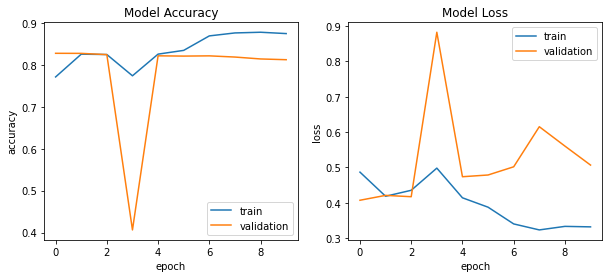

In [ ]:
plot_training_hist(history7)

Bi 4

In [ ]:
bi_lstm_model = Sequential(name="Bidirectional_LSTM")
bi_lstm_model.add(Embedding(len(tokenizer.word_index)+1, 100, input_length=max_length))
bi_lstm_model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=False)))
# bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(16, activation='relu'))
bi_lstm_model.add(Dense(1, activation='relu'))

print(bi_lstm_model.summary())

bi_lstm_model.compile(
loss="binary_crossentropy",
optimizer='adam',
metrics=['accuracy']
)

history8 = bi_lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=20, verbose=1, validation_data=(x_test, y_test))

print()
print("Bidirectional LSTM model Score---> ", bi_lstm_model.evaluate(x_test, y_test, verbose=0))


Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 311, 100)          1989200   
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 16)                4112      
                                                                 
 dense_24 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,227,825
Trainable params: 2,227,825
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
769/769 [==============================] - 37s 43ms/step - loss: 0.4840 - accuracy: 0.77

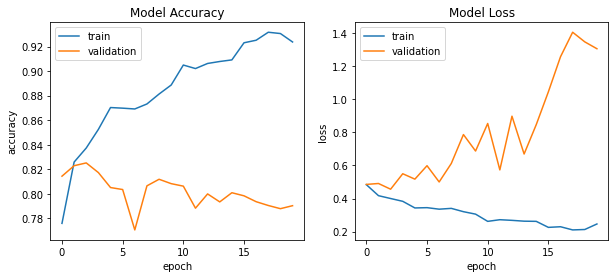

In [ ]:
plot_training_hist(history8)

BI 5

In [ ]:
# Defining LSTM model
bilstm_model = Sequential(name="BI LSTM_Model")
bilstm_model.add(Embedding(len(tokenizer.word_index)+1, 32, input_length=max_length))
bilstm_model.add(LSTM(64, return_sequences=True))
bilstm_model.add(LSTM(32))
bilstm_model.add(Dense(16, activation="relu"))
bilstm_model.add(Dense(1, activation="relu"))

# Printing Model Summary
print(lstm_model.summary())

# Compiling the model
lstm_model.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
history7 = lstm_model.fit(x_train_, y_train_, batch_size=64, epochs=50, verbose=1, validation_data=(x_valid, y_valid))

# Displaying the model accuracy on test data
print()
print("LSTM model Score---> ", lstm_model.evaluate(x_test, y_test, verbose=0))


Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 311, 32)           636544    
                                                                 
 lstm_22 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                272       
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 639,969
Trainable params: 639,969
Non-trai

LSTM 2

In [ ]:
lstm2 = Sequential()
lstm2.add(Embedding(len(tokenizer.word_index)+1, 32, input_length=max_length))
lstm2.add(Bidirectional(LSTM(32)))
lstm2.add(Dropout(0.5))
lstm2.add(Dense(16, activation='relu'))
lstm2.add(Dense(1, activation='softmax'))

# Printing model summary
print(lstm2.summary())

# Compiling model summary
lstm2.compile(
loss="binary_crossentropy",
optimizer='adam',
metrics=['accuracy']
)

# Training the model
history6 = lstm2.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_test, y_test))

# Printing model score on test data
print()
print("Bidirectional LSTM model Score---> ", lstm2.evaluate(x_test, y_test, verbose=0))

###Prediction

In [ ]:
def encode_text(tokenizer, text, max_length):
    encoded = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(encoded, maxlen=max_length)
    return padded

example_text = "positive"
encoded_text = encode_text(tokenizer, example_text, max_length)
prediction = bi_lstm_model.predict(encoded_text)

sentiment = np.round(prediction[0,0])

if sentiment == 0:
    print("Negative sentiment")
else:
    print("Positive sentiment")

1/1 [==============================] - 0s 57ms/step
[[0.5071797]]
Positive sentiment


In [66]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

model= Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 32, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.add(Dense(1))

# Printing model summary
print(model.summary())

# Compiling model summary
model.compile(
loss="binary_crossentropy",
optimizer='adam',
metrics=['accuracy']
)

# Training the model
history6 = model.fit(x_train_, y_train_, batch_size=64, epochs=10, verbose=1, validation_data=(x_test, y_test))

# Printing model score on test data
print()
print("Bidirectional LSTM model Score---> ", model.evaluate(x_test, y_test, verbose=0))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 311, 32)           636544    
                                                                 
 conv1d (Conv1D)             (None, 311, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 155, 32)          0         
 )                                                               
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 3)                

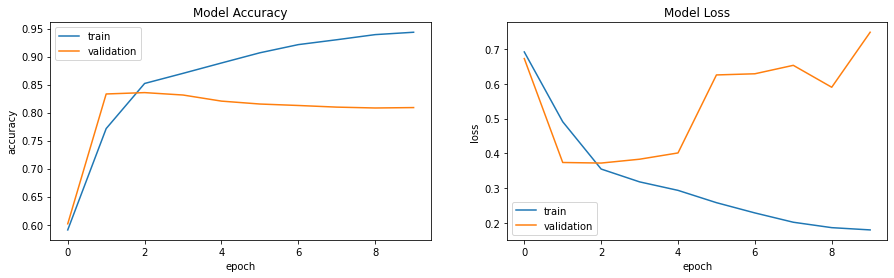

In [67]:
plot_training_hist(history6)